In [1]:
import keras
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


<h3>Cats vs Dogs</h3>
<p> 
We will be doing the <a href='https://www.kaggle.com/c/dogs-vs-cats'>Cats vs Dogs kaggle data challange</a>. With just a few lines of code and about 20 minutes of work, we can use Transfer Learning and the concept of Embedding to build a model that would have placed us in the top 20 of all challange entries circa 2013.</p>
<p>To keep things simple I have copied the code I used to read the dateset images in and resize them and save to the arrays to numpy matrices. Note this is not a particularly good thing to do it with image data, it just makes the preprocessing simpler and allows us to focus on model basics.
</p>

In [3]:
import glob
import PIL
import numpy as np
from sklearn import model_selection

p='/Users/frjo6001/Documents/DeepLearningTeamMeeting/dogs_v_cats/data/train/'
all_files = glob.glob(p+'*')

reprocess = False

if reprocess:
    # First resize and convert images to numpy array
    y   = np.empty((len(all_files)), np.int)
    x   = np.empty( (len(all_files),224,224,3), np.uint8 )

    for i,ff in enumerate(all_files):
        flg = 0 if 'cat' in ff.split('/')[-1] else 1

        y[i] = flg
        x[i] = np.array(PIL.Image.open(ff).resize((224,224)))


    x_train, x_test, y_train, y_test = model_selection.train_test_split(x,y,test_size=.2,stratify=y)
    del x
    
    np.savez_compressed('/Users/frjo6001/Documents/DeepLearningTeamMeeting/dogs_v_cats/dset.npz', 
                         x_train = x_train, 
                         x_test  = x_test, 
                         y_train = np.atleast_2d(y_train).T,
                         y_test  = np.atleast_2d(y_test).T
                       )

else:
    d=np.load('/Users/frjo6001/Documents/DeepLearningTeamMeeting/dogs_v_cats/dset.npz')
    x_train = d['x_train'] 
    x_test  = d['x_test'] 
    y_train = d['y_train']
    y_test  = d['y_test']

<p>First lets select some random images and see what we will be working with!</p>

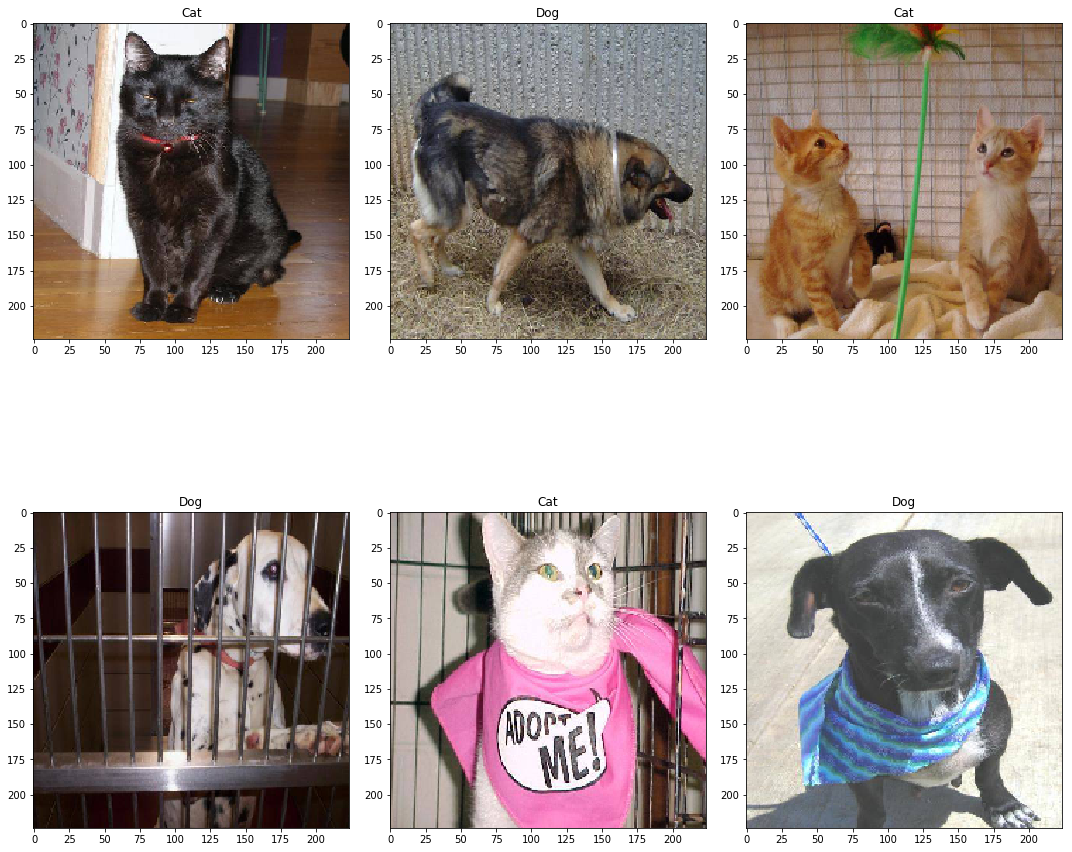

In [31]:
plt.figure(figsize=(15,15))
for i,idx in enumerate(np.random.randint(0,y_test.shape[0],6)):
    plt.subplot(2,3,i+1)
    plt.imshow(x_test[idx])
    plt.title('Dog' if y_test[idx] else 'Cat')

plt.tight_layout()

<h3>VGG16</h3>
<p><a href='https://arxiv.org/abs/1409.1556'>VGG16</a> is the name of a Neural Network Architecture for image recognition that won the <a href='http://www.image-net.org/challenges/LSVRC/'>ImageNet  ILSVRC-2014 competition</a>. It is no longer the best preforming architecture for image recognition but it is among the simplest to tinker with and consequently it is widely used.</p>
<p>Training an architecture like VGG16 from scratch is no trivial task, but fortunately both the weights and architecture of VGG16 are open source! Within a couple lines of code/a few minutes we can load up the VGG16 model that won imagenet 2014 and use it to do anything we want! This is the basis of transfer learning. We will use the feature extraction strategy learned by VGG16 on one set of images, and transfer it generate features for a completely different image set saving months of work and likley many thousands of dollars!</p>
<p>Because it is so commonly used keras makes it easy to import the vgg16 along with its weights. See  documentation for <b>keras.applications.VGG16</b> for details.</p>

In [3]:
keras.applications.VGG16??

In [97]:
x=keras.layers.Input((224,224,3))
vgg16 = keras.applications.VGG16( 
                                 input_tensor=x,
                                 )
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

<p>Unfortunately the images VGG was trained on had a different mean and color dimension ordering than the dog & cat images we are working with now. We could preprocess all the data before loading it into the model or we could do it on the fly while learning how to implenet a simple custom keras layer(called a Lambda layer). Lets build a lambda layer that will normalize the color channels and do necessary transformation as part of our model.</p>

In [94]:
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((1,1,3))
vgg_norm = keras.layers.Lambda(lambda x: x[:,:,::-1]-vgg_mean, 
                               output_shape=lambda x: x,
                              name='VGG_Norm')

<p>The imagenet competition our VGG model was optimized for sought to classify images into one of a 1,000 different catagories. Consiquently out VGG16 model generates a (1x1000) output vector for each input. (See model summary above) Lets modify our model to keep only the stages to do feature extraction.</p>
<p>Recent advances have made the last five layers in the vgg network more or less obsolete, so we can lop those off as well, and replace them with something more modern! While we are at it we can incorperate the custom layer above to prepare our image data.</p>

<p>In the code block below we will
    <ol><li>Apply custum vgg_norm layer to the model input.</li>
        <li>Pass our normzlied inputs through the convolutional filters devloped by the VGG creators</li>
        <li>Pass those convolutional filters through a keras.layers.GlobalAveragePooling2D object.</li>
    </ol>
   </p>

In [101]:
#Pass input through our custom normalization layer
input_image=keras.layers.Input((224,224,3))
x=vgg_norm(input_image)

#Throw away the last 5 layers of vgg and pass x through the remaining layers
#Set each vgg layer to trainable=False so keras will not change those weights!
keep_layers = [l for l in vgg16.layers[0:len(vgg16.layers)-5]]
for l in keep_layers:
    l.trainable=False
    x = l(x)
    
#Now add on the new layer
x = keras.layers.GlobalAveragePooling2D()(x)

In [102]:
#Create our new vgg model!
my_vgg = keras.models.Model(inputs=input_image, outputs=x)
my_vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
VGG_Norm (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
input_25 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
__________

<p>Running 5k images through vgg16 took ~36 minutes on my laptop cpu. You can run it if you like on both the test & training set data but I would rather not.</p>

In [34]:
out = my_vgg.predict(x_test,verbose=1,batch_size=32)

5000/5000 [==============================] - 2200s 440ms/step


<p>Fortunatly we have a gpu on odin, and running the same computation there took me ~30 seconds! You can download the (1x512) outputs for each image in the numpy archive <a href='https://drive.google.com/drive/folders/1fe5uNIqvJXO8HZZ6E8Ai5JEf4hoWRCcE?usp=sharing'>image_embedings.npz located here</a>. So lets just load these in and work with them.</p> 

In [52]:
data = np.load('/Users/frjo6001/Documents/DeepLearningTeamMeeting/dogs_v_cats/image_embedings.npz')

x_train = data['x_train']
y_train = data['y_train']

x_test = data['x_test']
y_test = data['y_test']

<p>
To build a classifyer on-top of these predictions we need to only apply:
<ol>
    <li><b>keras.layers.Input</b>   -- to stub out our input data</li>
    <li><b>keras.layers.Dropout</b> -- to prevent overfitting.</li>
    <li><b>keras.layers.Dense</b>   -- to transform our features into a binary 0/1 (cat/dog) flag!</li>
</ol>
Honestly a (pick you favorate package in sklearn) would probably work just as well here, but lets get the practice building models in keras!
</p>

In [61]:
inp = keras.layers.Input((512,))
x = keras.layers.Dropout(0.5)(inp)
out = keras.layers.Dense(1,activation=keras.activations.sigmoid)(x)
model = keras.models.Model(inp,out)
model.compile(keras.optimizers.Adam(), keras.losses.binary_crossentropy,metrics=['accuracy'])
model.fit( x=x_train, y=y_train,
           batch_size=32, epochs=5, 
           validation_data=(x_test,y_test),
           verbose=1
          )

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 1s 60us/step - loss: 0.5557 - acc: 0.8877 - val_loss: 0.0872 - val_acc: 0.9722
Epoch 2/5
20000/20000 [==============================] - 1s 40us/step - loss: 0.1993 - acc: 0.9447 - val_loss: 0.0840 - val_acc: 0.9720
Epoch 3/5
20000/20000 [==============================] - 1s 41us/step - loss: 0.1593 - acc: 0.9509 - val_loss: 0.0695 - val_acc: 0.9748
Epoch 4/5
20000/20000 [==============================] - 1s 41us/step - loss: 0.1395 - acc: 0.9523 - val_loss: 0.0598 - val_acc: 0.9776
Epoch 5/5
20000/20000 [==============================] - 1s 41us/step - loss: 0.1367 - acc: 0.9506 - val_loss: 0.0712 - val_acc: 0.9736


In [16]:
np.random.randint?